In [82]:
import os, sys
from pathlib import Path

project_path = Path(os.getcwd())
sys.path.append(str(project_path) +'/')

data_path = project_path/'data'/'morphomnist'/'global'

In [83]:
from utils.datasets import MorphomnistDataset

from utils.visualize import grid_show, img_grid

from torchvision import transforms 
from utils.customTransforms import ToFloatMNIST

batch_size = 64
dataset = MorphomnistDataset(data_path, transforms.Compose([ToFloatMNIST(),transforms.ToTensor()]), gz=True)

In [84]:
import torchvision.transforms.functional as F

def show_np(imgs, features, labels,xlabel=True, title=None, n=None):
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):        
        axs[0, i].imshow(np.asarray(img), cmap='cividis') 
        xlabel= make_label(features[i], labels[i]) if xlabel else None
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[], xlabel=xlabel)
    plt.suptitle(title)   
    plt.close()
    return fig
    
def make_label(features, label):
    return f"Label: {label},  Thickness: {features[0]:.2f},\n Area: {features[1]:.2f}, Slant: {features[2]:.2f}"

In [85]:
import torch
from  torch.utils.data import DataLoader,random_split
import math
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from automacaw_mmnist import automacaw_mmnist

In [86]:
m =len(dataset)
train_data, val_data = random_split(dataset, [math.floor(m-m*0.2), math.ceil(m*0.2)], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [87]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Train AE

In [ ]:
encoded_dim = 32
macaw_dim = 32

automacaw_model = automacaw_mmnist(encoded_dim, macaw_dim)
losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

In [94]:
early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

for epoch in (pbar := tqdm(range(100))):
    mse_train_loss = automacaw_model.train_ae(train_loader, lr=0.001)
    mse_val_loss = automacaw_model.test_MSE(val_loader)
    
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    
    if early_stopper.early_stop(mse_val_loss):             
        break    
        
#     clear_output()
#     fig = automacaw_model.plot_ae_outputs(val_loader)
    
    pbar.set_description(f"mse_train: {mse_train_loss:.6f}, mse_val: {losses['mse_val_loss'][-1]:.6f}")
#     display(fig)

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

(0.0, 0.05)

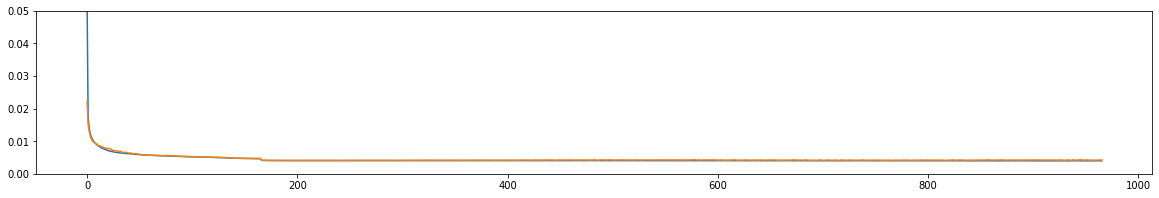

In [170]:
plt.plot(losses['mse_train_loss'])
plt.plot(losses['mse_val_loss'])
plt.ylim([0,0.05])

## Train Flow

In [96]:
automacaw_model.macaw = automacaw_model._init_macaw()
losses['nll_train_loss'] = []
losses['nll_val_loss'] = []

In [97]:
early_stopper = EarlyStopper(patience=3, min_delta=0.1)

for epoch in (pbar := tqdm(range(300))):
    nll_train_loss = automacaw_model.train_macaw(train_loader, lr=0.0001)
    nll_val_loss = automacaw_model.test_likelihood(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
#     clear_output()
#     fig = cf_test(automacaw_model,val_loader)
    
#     print(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
#     display(fig)
    
    pbar.set_description(f"nll_train: {nll_train_loss:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    
    
    if early_stopper.early_stop(nll_val_loss):             
        break    
        
#     clear_output()
#     fig = automacaw_model.plot_ae_outputs(val_loader)
    


  0%|          | 0/300 [00:00<?, ?it/s]

label 0
thickness 2
slant 0.3


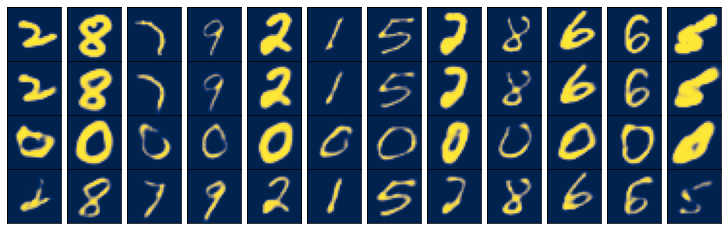

In [136]:
automacaw_model.cf_test(val_loader)

In [99]:
# import pickle
# with open(project_path/'models'/'MMNIST_model.pkl', 'wb') as f:
#     pickle.dump({'model':automacaw_model, 'losses':losses}, f)

In [150]:
self = automacaw_model
cf_vals = {'label':0}

batch = next(iter(val_loader))
obs = batch[0].detach().cpu().numpy()[:10]

self.encoder.eval()
self.macaw.eval()
self.decoder.eval()

cf_vals = self._cfvals_transform(cf_vals)

with torch.no_grad():
    x_obs, latents = self._batch_to_x(batch)
    x_cf = self._cf(x_obs, cf_vals)
    recons = self._x_to_batch(x_cf, latents)

label 0


In [155]:
recons[0][0].shape

(28, 28)

In [148]:
obs.shape

(10, 1, 28, 28)

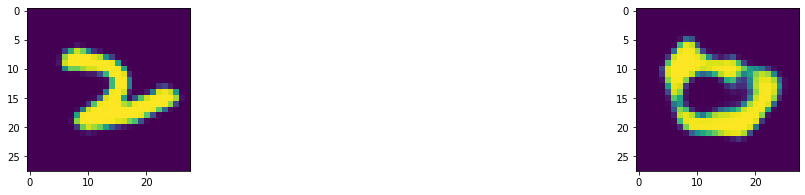

In [156]:
fig,axs = plt.subplots(1,2)
axs[0].imshow(np.squeeze(obs[0]))
axs[1].imshow(np.squeeze(recons[0][0]))

In [157]:
x_obs = x_obs.detach().cpu().numpy()
x_cf = x_cf.detach().cpu().numpy()

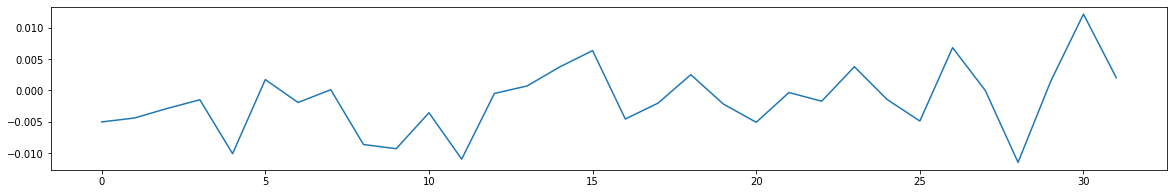

In [169]:
plt.plot(np.mean(x_obs[:,13:]-x_cf[:,13:], axis=0))
# plt.plot(x_cf[7,13:])

In [130]:
with open(project_path/'models'/'MMNIST_model.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

## Fine Tune

In [117]:
alpha = 0.015
beta = 800

for epoch in (pbar := tqdm(range(150))):
    nll_train_loss, mse_train_loss = automacaw_model.train(train_loader, alpha=alpha, beta=beta,lr=0.0001)
    nll_val_loss, mse_val_loss = automacaw_model.test(val_loader)
    
    losses['nll_train_loss'].append(nll_train_loss)
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(mse_val_loss)
    losses['nll_val_loss'].append(nll_val_loss)
    
    # clear_output()
    # fig = cf_test(automacaw_model,val_loader,12)
    
    pbar.set_description(f"mse_train: {mse_train_loss:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_train: {nll_train_loss: .3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    # display(fig)

  0%|          | 0/150 [00:00<?, ?it/s]

In [122]:
# import pickle
# with open(project_path/'models'/'MMNIST_model_joint.pkl', 'wb') as f:
#     pickle.dump({'model':automacaw_model, 'losses':losses}, f)

In [134]:
with open(project_path/'models'/'MMNIST_model_joint.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

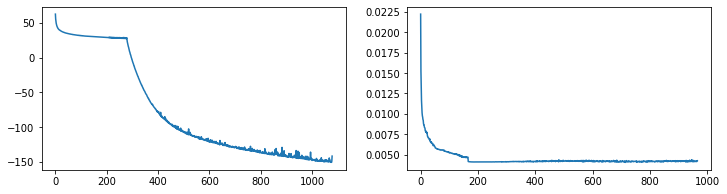

In [179]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
axs[0].plot(losses['nll_val_loss'])
axs[1].plot(losses['mse_val_loss'])
plt.savefig('joint_loss_MMNIST.pdf')

In [186]:
fig = automacaw_model.cf_test(test_loader)

fig.savefig('MMNIST_CF.pdf')

label 0
thickness 2
slant 0.3


In [184]:
test_dataset = MorphomnistDataset(data_path, transforms.Compose([ToFloatMNIST(),transforms.ToTensor()]), test=True,gz=True)

test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Classification

In [191]:
with open(project_path/'models'/'MMNIST_model.pkl', 'rb') as f:
    o = pickle.load(f)

automacaw_model = o['model']
losses = o['losses']

In [192]:
nll_test_loss, mse_test_loss = automacaw_model.test(test_loader)
nll_test_loss, mse_test_loss

(28.344875, 0.0050466275)

In [185]:
labels = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        bs = batch[0].shape[0]
        x, latents = automacaw_model._batch_to_x(batch)
        labels+=batch[2].detach().cpu().numpy().tolist()

        x[:,:10] = 0 
        x = x.repeat((10,1))

        for i in range(10):
            x[i*bs:i*bs+bs,i] = 1
            
        ll = automacaw_model.macaw.log_likelihood(x).reshape(10,bs)
        predictions+=(np.argmax(ll,axis=0).tolist())
             

accuracy = sum([(l==p) * 1 for l,p in zip(labels,predictions)])/len(predictions)
accuracy

0.9608

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)
encoded_dim = 64

separate_losses = {}
joined_losses = {}

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):   
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # train_dataset = torch.utils.data.Subset(dataset,train_ids)
    # val_dataset = torch.utils.data.Subset(dataset,test_ids)
       
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)  

    automacaw_model = automacaw(encoded_dim)
    losses = {'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}
  
    for epoch in (pbar := tqdm(range(60))):
        losses['mse_train_loss'].append(automacaw_model.train_encoder_decoder(train_loader))
        losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
        pbar.set_description(f"mse_train: {losses['mse_train_loss'][-1]:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}")
    
    for e in (pbar := tqdm(range(50))):
        losses['nll_train_loss'].append(automacaw_model.train_macaw(train_loader))
        losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))
        pbar.set_description(f"nll_train: {losses['nll_train_loss'][-1]:.3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
    separate_losses[fold] = losses
    

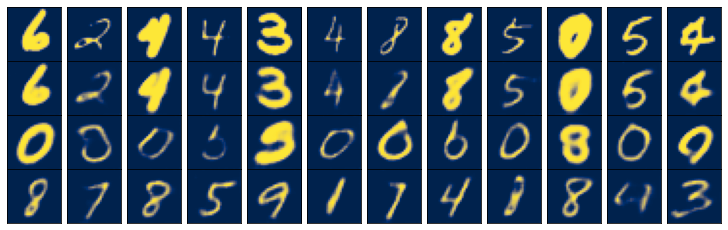

In [19]:
alpha = 0.0001
beta = 2200
losses = {'total_loss':[], 'mse_train_loss':[],'mse_val_loss':[],'nll_train_loss':[],'nll_val_loss':[]}

automacaw_model = automacaw(encoded_dim)

for epoch in (pbar := tqdm(range(50))):

    nll_train_loss, mse_train_loss, total_loss = automacaw_model.train_everything(train_loader, alpha=alpha, beta=beta)
    losses['nll_train_loss'].append(nll_train_loss)
    losses['mse_train_loss'].append(mse_train_loss)    
    losses['mse_val_loss'].append(automacaw_model.test_MSE(val_loader))
    losses['nll_val_loss'].append(automacaw_model.test_likelihood(val_loader))

    clear_output()
    display(automacaw_model.cf_test(val_loader,12)) 

    pbar.set_description(f"total_loss: {total_loss:.3f}, mse_train: {mse_train_loss:.3f}, mse_val: {losses['mse_val_loss'][-1]:.3f}, nll_train: {nll_train_loss: .3f}, nll_val: {losses['nll_val_loss'][-1]:.3f}")
joined_losses[fold] = losses    

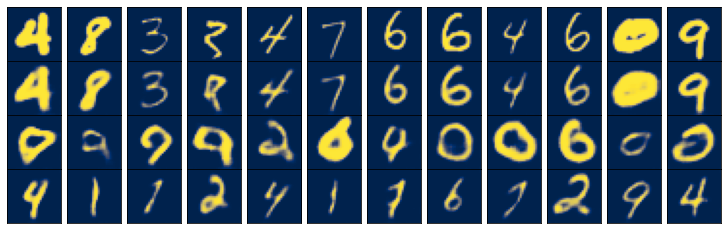

In [ ]:
automacaw_model.cf_test(val_loader,12)


In [ ]:
import pickle
with open(macaw_path/'results'/'MIDL2024'/'MMNIST_losses.pkl', 'wb') as f:
    pickle.dump({'separate_losses':separate_losses, 'joined_losses':joined_losses}, f)

In [ ]:
with open(macaw_path/'results'/'MIDL2024'/'MMNIST_losses.pkl', 'rb') as f:
    losses = pickle.load(f)

separate_losses = losses['separate_losses']
joined_losses = losses['joined_losses']

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5,5)

def mean_plot(d,key, fold=5):  
    losses = [d[i][key]for i in range(fold)]
    return np.mean(losses, axis=0), np.std(losses, axis=0)

sep_mse_mean, sep_mse_std = mean_plot(separate_losses,'mse_val_loss')
jon_mse_mean, jon_mse_std = mean_plot(joined_losses,'mse_val_loss')

sep_nll_mean, sep_nll_std = mean_plot(separate_losses,'nll_val_loss')
jon_nll_mean, jon_nll_std = mean_plot(joined_losses,'nll_val_loss')

NameError: name 'separate_losses' is not defined

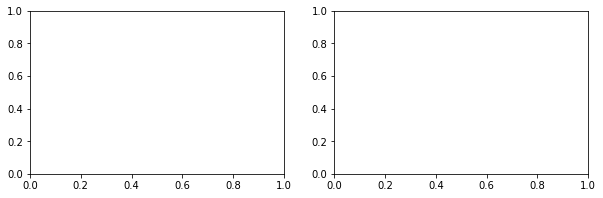

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,3)

fig, axs =  plt.subplots(1,2)

axs[0].plot(separate_losses[0]['mse_train_loss'], color='purple')
axs[0].plot(joined_losses[0]['mse_train_loss'], color='steelblue')
axs[0].set(ylim=[0.004,0.08])

# axs[0].fill_between(np.arange(60), sep_mse_mean - sep_mse_std/np.sqrt(5), sep_mse_mean + sep_mse_std/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[0].fill_between(np.arange(60), jon_mse_mean[10:70] - jon_mse_std[10:70]/np.sqrt(5), jon_mse_mean[10:70] + jon_mse_std[10:70]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)

axs[1].plot(separate_losses[0]['nll_train_loss'], color='purple')
axs[1].plot(joined_losses[0]['nll_train_loss'], color='steelblue')
axs[1].set(ylim = [-10000,-2000])

# axs[1].fill_between(np.arange(30), sep_nll_mean[:30] - sep_nll_std[:30]/np.sqrt(5), sep_nll_mean[:30] + sep_nll_std[:30]/np.sqrt(5),
#                  color='purple', alpha=0.2)

# axs[1].fill_between(np.arange(30), jon_nll_mean[70:100] - jon_nll_std[70:100]/np.sqrt(5), jon_nll_mean[70:100] + jon_nll_std[70:100]/np.sqrt(5),
#                  color='steelblue', alpha=0.2)